In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot
from ipywidgets import interact, interact_manual
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [2]:
# My aim in this assignment is to examine two relationships: 1) graduate earnings and instruction spending share
# of total expenditure; and 2) graduate earnings and tuition and fees share of total revenue. I then split the data 
# up by institutional status, urban/rural setting, and Historically Black College and University (HBCU) status to 
# observe other interesting patterns. 

# I begin by defining a function to read and clean the data I downloaded from the Urban Institute.

def read_clean_csv(csv_string, column_list, na_list, xwalk):
    df = pd.read_csv(os.path.join(os.getcwd(), csv_string),
                     usecols = column_list,
                     na_values = na_list)
    df = df.dropna()
    df["inst_name"] = [txt.lower().capitalize() for txt in df["inst_name"]]
    df['inst_name'] = [txt.replace('.', '') for txt in df['inst_name']]
    df['inst_name'] = [txt.replace('-', ' ') for txt in df['inst_name']]
    df['inst_name'] = df['inst_name'].replace(xwalk)
    return df

In [3]:
# This cell defines variables that I insert into the above read_clean_csv function to read my first dataframe, 
# md_edu_info, which provides expenditure, earnings, and other information about higher education institutions 
# in Maryland. Beyond the initial function, I exclude certain years (more on that below), I calculate the share of 
# instruction spending in total expenditure, the share of tuition and fees in total revenue, and I collapse the 
# 'urban_centric_locale' variable into just two values: urban and rural. 

info_columns = ['year', 'inst_name', 'inst_control',
                'hbcu', 'urban_centric_locale', 
                'rev_tuition_fees_gross', 'rev_total_current',
                'exp_instruc_total', 'exp_total_current']

info_na = ["Missing/not reported", ""]

# Different names of the same institutions needed to be fixed.  
xwalk_name = {'Coppin state college': 'Coppin state university', 
              'Loyola college in maryland': 'Loyola university maryland',
              'Loyola college': 'Loyola university maryland',
              'Mount saint marys college': "Mount st mary's university",
              'University of phoenix maryland campus': 'University of phoenix maryland',
              'Sojourner douglas college': 'Sojourner douglass college',
              'Villa julie college': 'Stevenson university',
              'The national labor college': 'National labor college',
              'Saint marys seminary and university': "St mary's seminary & university"}

md_edu_info = read_clean_csv("md_edu_info.csv", info_columns, info_na, xwalk_name)

# Becuase I am focusing on earnings of graduates 10 years after entry into higher education from 2007-2014, 
# instruction spending and tuition levels after 2008 likely did not affect them, so I drop those values.
yr_indices = md_edu_info[md_edu_info['year'] > 2008].index 
md_edu_info.drop(yr_indices, inplace=True)

md_edu_info['instruc_exp_share'] = md_edu_info['exp_instruc_total']/md_edu_info['exp_total_current']

md_edu_info['tuition_fees_rev_share'] = md_edu_info['rev_tuition_fees_gross']/md_edu_info['rev_total_current']

# One observation had more than 100% of revenue from tuition and fees, which did not make sense to me, 
# so I excluded it.
md_edu_info = md_edu_info[md_edu_info['tuition_fees_rev_share'] < 1]

xwalk_geo = {k:[] for k in md_edu_info["urban_centric_locale"].unique()}

for k in xwalk_geo:
    for i in ['City', 'city', 'Suburb']:
        if i in k:
            xwalk_geo[k].append('Urban')
        else: pass
    for w in ['Rural', 'Town', 'town']:
        if w in k:
            xwalk_geo[k].append('Rural')
        else: pass
        
md_edu_info['urban_centric_locale'] = md_edu_info['urban_centric_locale'].replace(xwalk_geo)

In [4]:
# I do the same as above for my next dataframe, md_edu_earnings, which contains information on male and female
# graduate earnings. I limited my data to earnings of graduates 10 years after entry into their institutions. Mean
# earnings are calculated by average male and female earnings. 

earnings_columns = ['year', 'inst_name', 'years_after_entry',  
                    'earnings_female_mean', 'earnings_male_mean']

earnings_na = ["Suppressed data"]

md_edu_earnings = read_clean_csv('md_edu_earnings.csv', earnings_columns, earnings_na, xwalk_name)

md_edu_earnings = md_edu_earnings[md_edu_earnings["years_after_entry"] == 10]

md_edu_earnings["earnings_mean"] = (md_edu_earnings["earnings_male_mean"] + 
                                    md_edu_earnings["earnings_female_mean"])/2

In [5]:
# Here, I merge the two dataframes loaded and cleaned above, remove extraneous columns, and rename variables for 
# clarity and in anticipation of how they will appear in my interactive plots.

md_edu_info_earn = md_edu_info.merge(md_edu_earnings, on="inst_name")

to_delete = ["rev_tuition_fees_gross", 
             "rev_total_current", 
             "exp_instruc_total", 
             "exp_total_current", 
             "years_after_entry"]

for k in to_delete:
    md_edu_info_earn.pop(k)
    
md_edu_info_earn.rename(columns = {"year_x": "exp_year", "year_y": "earnings_year",
                                   "inst_control": "Institution Status",
                                   "urban_centric_locale": "Urban/Rural",
                                   "hbcu": "HBCU"},
                        inplace=True)

In [6]:
# I define a function for a static grid of four axes showing scatterplots of the variables of interest with 
# different coloring depending on institutional and geographic settings. 

def make_axes(df, x, y, 
              ax00_title, 
              ax01_title, ax01_var, ax01_subset1, ax01_subset2, ax01_subset3,
              ax10_title, ax10_var, ax10_subset1, ax10_subset2,
              ax11_title, ax11_var, ax11_subset1, ax11_label1, ax11_subset2, ax11_label2,
              common_xlabel, common_ylabel,
              axes_title):
    fig, axs = plt.subplots(2, 2, figsize=(12,8))
    axs[0, 0].scatter(df[x], 
                  df[y], 
                  color='blue')
    axs[0, 0].set_title(ax00_title)
    axs[0, 0].spines['right'].set_visible(False)
    axs[0, 0].spines['top'].set_visible(False)
    axs[0, 1].scatter(df[df[ax01_var] == ax01_subset1][x], 
                  df[df[ax01_var] == ax01_subset1][y],
                  label=ax01_subset1,
                  color='blue')
    axs[0, 1].scatter(df[df[ax01_var] == ax01_subset2][x], 
                  df[df[ax01_var] == ax01_subset2][y],
                  label=ax01_subset2,
                  color='orange')
    axs[0, 1].scatter(df[df[ax01_var] == ax01_subset3][x], 
                  df[df[ax01_var] == ax01_subset3][y],
                  label=ax01_subset3,
                  color='black')
    axs[0, 1].legend()
    axs[0, 1].set_title(ax01_title)
    axs[0, 1].spines['right'].set_visible(False)
    axs[0, 1].spines['top'].set_visible(False)
    axs[1, 0].scatter(df[df[ax10_var] == ax10_subset1][x], 
                  df[df[ax10_var] == ax10_subset1][y],
                  label=ax10_subset1,
                  color='blue')
    axs[1, 0].scatter(df[df[ax10_var] == ax10_subset2][x], 
                  df[df[ax10_var] == ax10_subset2][y],
                  label=ax10_subset2,
                  color='orange')
    axs[1, 0].set_title(ax10_title)
    axs[1, 0].legend()
    axs[1, 0].spines['right'].set_visible(False)
    axs[1, 0].spines['top'].set_visible(False)
    axs[1, 1].scatter(df[df[ax11_var] == ax11_subset1][x], 
                  df[df[ax11_var] == ax11_subset1][y], 
                  label=ax11_label1,
                  color='blue')
    axs[1, 1].scatter(df[df[ax11_var] == ax11_subset2][x], 
                  df[df[ax11_var] == ax11_subset2][y], 
                  label=ax11_label2,
                  color='orange')
    axs[1, 1].set_title(ax11_title)
    axs[1, 1].legend()
    axs[1, 1].spines['right'].set_visible(False)
    axs[1, 1].spines['top'].set_visible(False)
    fig.text(0.5, 0.04, 
         common_xlabel, 
         ha='center', 
         va='center',
         size=14) # Source: https://stackoverflow.com/questions/6963035/pyplot-axes-labels-for-subplots
    fig.text(0.06, 0.5, 
         common_ylabel, 
         ha='center', 
         va='center', 
         rotation='vertical',
         size=14)
    fig.suptitle(axes_title,
             size=15);
    return plt.show()

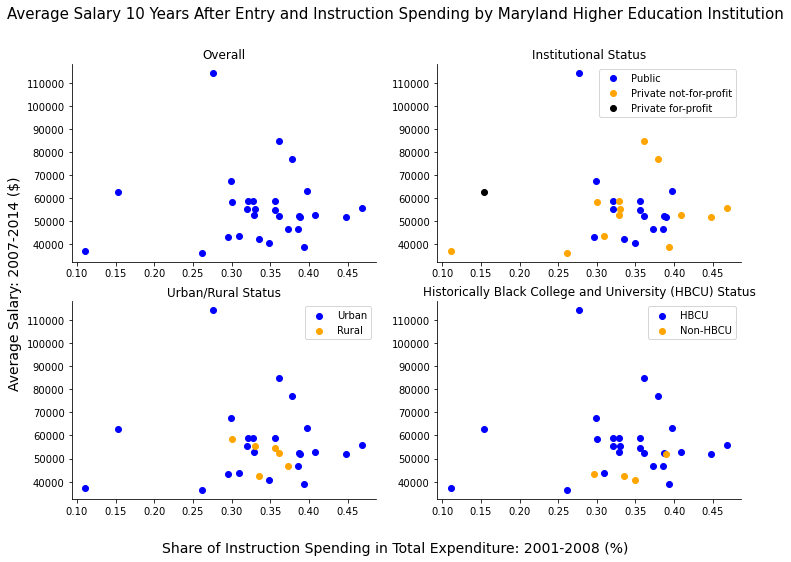

In [7]:
# Scatterplots showing relationship between earnings and instruction expenditure. 

info = md_edu_info_earn.groupby(['inst_name', 'Institution Status', 
                                 'Urban/Rural', 'HBCU']).mean().reset_index()

make_axes(info, 'instruc_exp_share', 'earnings_mean',
          'Overall',
          'Institutional Status', 'Institution Status', 'Public', 'Private not-for-profit', 'Private for-profit',
          'Urban/Rural Status', 'Urban/Rural', 'Urban', 'Rural',
          'Historically Black College and University (HBCU) Status', 'HBCU', 'No', 'HBCU', 'Yes', 'Non-HBCU',
          'Share of Instruction Spending in Total Expenditure: 2001-2008 (%)', 'Average Salary: 2007-2014 ($)',
          'Average Salary 10 Years After Entry and Instruction Spending by Maryland Higher Education Institution')

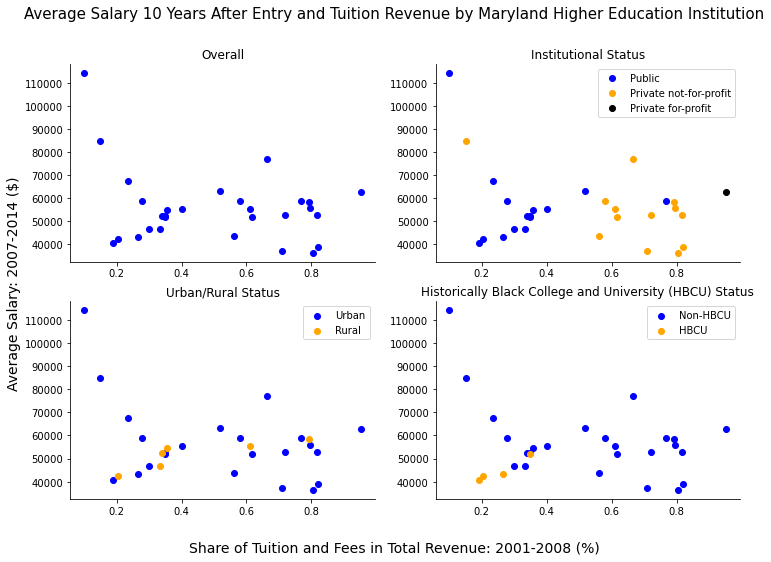

In [8]:
# Scatterplots showing relationship between earnings and tuition and fees. 

make_axes(info, 'tuition_fees_rev_share', 'earnings_mean',
          'Overall',
          'Institutional Status', 'Institution Status', 'Public', 'Private not-for-profit', 'Private for-profit',
          'Urban/Rural Status', 'Urban/Rural', 'Urban', 'Rural',
          'Historically Black College and University (HBCU) Status', 'HBCU', 'No', 'Non-HBCU', 'Yes', 'HBCU',
          'Share of Tuition and Fees in Total Revenue: 2001-2008 (%)', 'Average Salary: 2007-2014 ($)',
          'Average Salary 10 Years After Entry and Tuition Revenue by Maryland Higher Education Institution')

In [9]:
# Functions to define line graphs that show changes in earnings over time.

def subset_earn(indicator, value):
    df = md_edu_info_earn[md_edu_info_earn[indicator] == value].groupby("earnings_year").mean().reset_index()
    return df

def plot_earnings(indicator, value):
    plot = figure(title='Average Salary 10 Years After Entry for Maryland Higher-Ed Institutions (2007-2014)', 
              x_axis_label='Year', y_axis_label='Salary ($)', plot_height=400)
    plot.line(subset_earn(indicator, value)["earnings_year"], 
          subset_earn(indicator, value)["earnings_male_mean"], 
          line_width=4, color="orange", legend_label="Male")
    plot.line(subset_earn(indicator, value)["earnings_year"], 
          subset_earn(indicator, value)["earnings_female_mean"], 
          line_width=4, color="blue", legend_label="Female")
    plot.line(subset_earn(indicator, value)["earnings_year"], 
          subset_earn(indicator, value)["earnings_mean"], 
          line_width=4, color="black", legend_label="Average")
    return plot

In [10]:
# Interactive plot showing male, female, and average graudate earnings from 2007-2014 filtered by different 
# indicators and values. I would have liked for the values options to update dynamically depending on the indicator
# selected, but I could not get that to work. However, when aligned correctly, the options produce the proper plots.

indicators = ['Institution Status', 'Urban/Rural', 'HBCU']
values = ['Public', 'Private not-for-profit', 'Private for-profit',
          'Urban', 'Rural', 'Yes', 'No']

@interact(indicators=indicators, values=values)
def make_plot_for(indicators=indicators[0], values=values[0]):        
    plot = plot_earnings(indicators, values)
    show(plot)

interactive(children=(Dropdown(description='indicators', options=('Institution Status', 'Urban/Rural', 'HBCU')…

In [11]:
# Functions for my interactive plot on instruction expenditure and tuition changes over time.

def subset_exp(indicator, value):
    df = md_edu_info_earn[md_edu_info_earn[indicator] == value].groupby("exp_year").mean().reset_index()
    return df

def plot_exp(indicator, value):
    plot = figure(title='Instruction and Tuition Shares of Spending and Revenue, Respecitvely (2001-2008)', 
              x_axis_label='Year', y_axis_label='Share of Total (%)', plot_height=400)
    plot.line(subset_exp(indicator, value)["exp_year"], 
          subset_exp(indicator, value)["instruc_exp_share"], 
          line_width=4, color="orange", legend_label="Instruction")
    plot.line(subset_exp(indicator, value)["exp_year"], 
          subset_exp(indicator, value)["tuition_fees_rev_share"], 
          line_width=4, color="blue", legend_label="Tuition and Fees")
    return plot

@interact(indicators=indicators, values=values)
def make_plot_for(indicators=indicators[0], values=values[0]):        
    plot = plot_exp(indicators, values)
    show(plot)

interactive(children=(Dropdown(description='indicators', options=('Institution Status', 'Urban/Rural', 'HBCU')…

This was a challenging assignment that really stretched my skills at cleaning, plotting, and using functions. Perhaps the most challenging part of the data cleaning process was fixing institution names, which had different spellings and capitalizations for the same institutions. Although I could automate new capitalization standards, fixing other idiosyncracies with naming required some hard coding. It was good to be able to include the cleaning tasks that applied to both data sets I used in a function, which made the code much cleaner in the end. Functions were also very helpful for plotting. Since my plots conveyed different information in similar ways, I could recycle my functions. 

The results of my plots show that there is some correlation between earnings and instruction expenditure. There is a noteworthy difference between public and private institutions when it comes to the amount of tuition and fees as part of total revenue. This is likely because many in-state public university students pay less in tuition. However, the amount of tuition revenue doesn't seem to matter for earnings. 

From 2007 to 2014, male graduates overall earned more than female graudates across institutional and geographic settings. Notably, earnings of graduates from Historically Black Colleges and Universities - particularly female graduates - declined more sharply than graduates from other settings in the aftermath of the Great Recession. A noteworthy result from instruction spending and tuition trends from 2001 to 2008 was the very sharp decline of tuition and fees among rural colleges during the Great Recession.  